In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.formula.api import ols

from matplotlib import pyplot as plt

from sklearn import linear_model
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

import seaborn as sns

import pickle

In [2]:
nba_data = pd.read_csv('Finalized_nba_data_for_modeling.csv', index_col = 0)

In [3]:
nba_data['TS%'] = [x/10 for x in nba_data['TS%']]

# turning TS% into the avergae for the team as it was originally the sum 

Applying all the interactions that were found to be the best from the multiple models

In [4]:
nba_data['TS_Ast'] = [nba_data['TS%'][i]*nba_data['AST%'][i] for i in range(len(nba_data['TS%']))]

In [5]:
nba_data['TS_ORB'] = [nba_data['TS%'][i]*nba_data['ORB%'][i] for i in range(len(nba_data['TS%']))]

In [6]:
nba_data['TS_Pts'] = [nba_data['TS%'][i]*nba_data['PTS'][i] for i in range(len(nba_data['TS%']))]

Removing the collinear and weak features found in the models

In [7]:
nba_data = nba_data.drop(columns = ['ORB%', '3PAr', 'FTr', 'AST%', '3P%', 'PTS', 'FT%'])

Creating Target and Features

In [8]:
target = nba_data['W']

In [9]:
features_list = []

In [10]:
for x in nba_data:
    if (x == 'W') or (x == 'Tm') or (x == 'year') or (x == 'Pace'):
        pass
    else:
        features_list.append(x)

In [11]:
features = nba_data[features_list]

Train Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=23,test_size=0.2)  

Applying Scalar (Standard Scalar) - Using it to get a better view of the data in the models and have a better idea of final results

In [13]:
scaler = StandardScaler()
final_scaler = scaler.fit(X_train)
X_train =pd.DataFrame(data=scaler.transform(X_train), columns=features_list)
X_test =pd.DataFrame(data=scaler.transform(X_test), columns=features_list)

Lasso Test - Turned out to be the best type of model after comparing results in multiple scenarios

In [14]:
from sklearn.linear_model import Lasso

In [15]:
lasso = Lasso(alpha=0.01, max_iter = 5000, normalize=False)

final_lasso = lasso.fit(X_train,y_train)

y_train_pred_lasso = lasso.predict(X_train)
y_pred_lasso = lasso.predict(X_test)

train_rmse = metrics.mean_absolute_error(y_train, y_train_pred_lasso)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_lasso))
print('Training Error: '+ str(train_rmse))
print('Testing Error: '+ str(test_rmse))

Training Error: 3.7935826618971173
Testing Error: 5.72745611011417


Viewing Lasso data as a graph

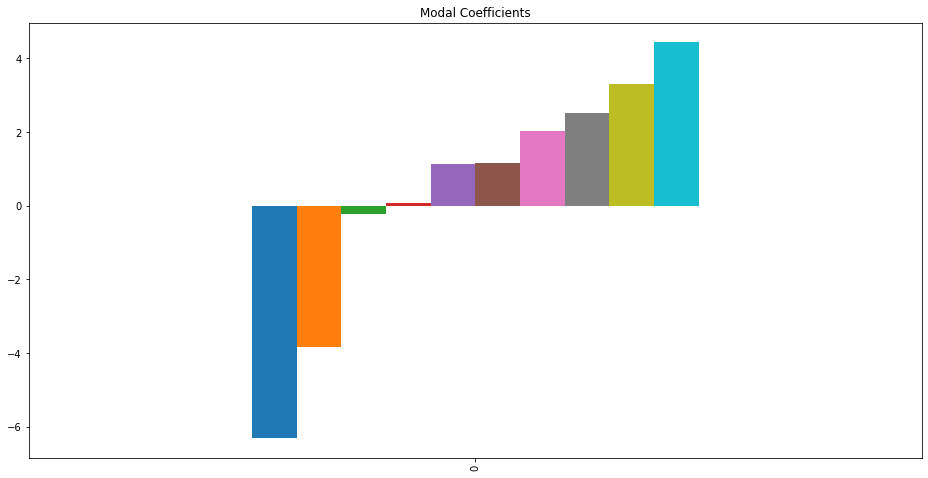

In [16]:
lasso_coef01 = pd.DataFrame(data=lasso.coef_).T
lasso_coef01.columns = X_train.columns
lasso_coef01 = lasso_coef01.T.sort_values(by=0).T
lasso_coef01.plot(kind='bar', title='Modal Coefficients', legend=False, figsize=(16,8))

In [17]:
lasso_coef01.T

,0
Dfg%,-6.298125
TOV,-3.823258
BLK%,-0.218078
TS_Ast,0.065958
Age,1.138108
TRB%,1.160551
TS_ORB,2.016628
STL%,2.502568
TS%,3.298707
TS_Pts,4.431130


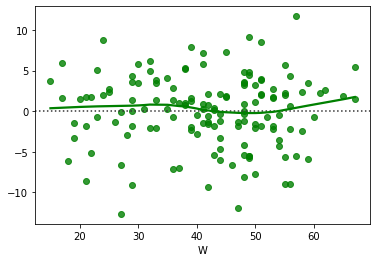

In [18]:
sns.residplot( y_train, y_train_pred_lasso,lowess=True, color="g")

Final Check of Collinearity of the Data

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [20]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
vif.round(5)

,VIF Factor,features
0,1.60656,Age
1,1.32837,Dfg%
2,1.62601,TOV
3,3.90208,TS%
4,1.51753,TRB%
5,1.42170,STL%
6,1.36524,BLK%
7,1.61394,TS_Ast
8,1.45159,TS_ORB
9,3.23329,TS_Pts


Checking *R^2* Value

In [21]:
X_endog = sm.add_constant(X_test)

In [22]:
res = sm.OLS(list(y_test), X_endog)

In [24]:
res.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     29.27
Date:                Thu, 07 May 2020   Prob (F-statistic):           2.44e-11
Time:                        09:20:45   Log-Likelihood:                -99.675
No. Observations:                  36   AIC:                             221.3
Df Residuals:                      25   BIC:                             238.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.0949      0.900     45.658      0.000      39.241      42.949
Age           -0.2209      1.396     -0.158      0.876      -3.097       2.655
Dfg%         -10.8910      1.338     -8.138      0.000     -13.647      -8.135
TOV           -5.9584      1.309     -4.552      0.000      -8.654      -3.262
TS%            1.8702      1.565      1.195      0.243      -1.353       5.094
TRB%           0.4324      1.074      0.403      0.691      -1.779       2.644
STL%           1.9993      0.869      2.301      0.030       0.210       3.789
BLK%          -1.2496      0.792     -1.578      0.127      -2.880       0.381
TS_Ast         1.5851      1.097      1.445      0.161      -0.674       3.844
TS_ORB         2.0995      1.000      2.098      0.046       0.039       4.160
TS_Pts         5.7549      1.530      3.762      0.001       2.604       8.906
==============================================================================
Omnibus:                        0.089   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.957   Jarque-Bera (JB):                0.024
Skew:                          -0.016   Prob(JB):                        0.988
Kurtosis:                       2.879   Cond. No.                         5.25
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The final model included 9 features the 4 most valuable, according to the Lasso model were, DFG%, TS_Pts and TOVs. 

DFG% was the most effective tool, this is the shooting % of the other team, and it had a large affect on the data which makes sense, and goes with my original idea that defense should a big proponent in wins

TS_Pts also made sense. As they show the efficiency of scoring with TS_Pts. The volume of scoring but doing so at an efficient rate is a large proponent of wins

TOV is a measure of possessions. This is negatively correlated as expected as less turnovers means you have the ball more. This goes with DFG% as if you have a higher rate of turnovers and more possessions it will lead to the most efficiency. 

*Honorable mention to Age which had a high correlation and i believe this is due to the trend of tanking in the nba which has become much more prevelant in the last decade where more teams will completely rebuild their rosters from the ground up and go all in on youth to lose more on purpose.* 
 